In [106]:
import torch

from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.lrelu = nn.LeakyReLU(negative_slope=0.2)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2, stride=2, padding=0),
            self.lrelu
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=2, stride=2, padding=0),
            self.lrelu
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=2, stride=2, padding=0),
            self.lrelu
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=80, kernel_size=2, stride=2, padding=0),
            self.lrelu
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=64, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        # print(f"{x.size()}")
        x = self.block2(x)
        # print(f"{x.size()}")
        x = self.block3(x)
        # print(f"{x.size()}")
        x = self.block4(x)
        # print(f"{x.size()}")
        x = self.block5(x)
        # print(f"{x.size()}", end="\n\n")
        return x

In [108]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.lrelu = nn.LeakyReLU(negative_slope=0.2)

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=80, kernel_size=1, stride=1, padding=0),
            self.lrelu,
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=80, out_channels=25, kernel_size=2, stride=2, padding=0),
            self.lrelu,
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=25, out_channels=10, kernel_size=2, stride=2, padding=0),
            self.lrelu,
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=10, out_channels=3, kernel_size=2, stride=2, padding=0),
            self.lrelu,
        )
        self.block5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=2, stride=2, padding=0)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        # print(f"{x.size()}")
        x = self.block2(x)
        # print(f"{x.size()}")
        x = self.block3(x)
        # print(f"{x.size()}")
        x = self.block4(x)
        # print(f"{x.size()}")
        x = self.block5(x)
        # print(f"{x.size()}")
        return x

In [109]:
class VAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encode = Encoder()
        self.decode = Decoder()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encode(x)
        x = self.decode(x)
        return x

In [110]:
import torch
import torch.nn.functional as function


def resize_to_multiple_of_16(tensor: torch.Tensor, mode="bicubic") -> torch.Tensor:
    """
    Resizes tensor (N, C, H, W) or (C, H, W) such that H and W are multiples of 16.
    :param tensor: tensor to resize
    :param mode: rescale mode
    :return: resized tensor
    """
    orig_h, orig_w = tensor.shape[-2], tensor.shape[-1]

    new_h = round(orig_h / 16) * 16
    new_w = round(orig_w / 16) * 16

    if tensor.ndim == 3:  # (C, H, W)
        tensor = tensor.unsqueeze(0)  # Add batch dim -> (1, C, H, W)
        resized = function.interpolate(tensor, size=(new_h, new_w), mode=mode, align_corners=False)
        resized = resized.squeeze(0)  # Remove batch dim -> (C, H, W)
    else:  # (N, C, H, W)
        resized = function.interpolate(tensor, size=(new_h, new_w), mode=mode, align_corners=False)

    return resized

In [111]:
# test_model = VAE(hidden_channels=16)
#
# test_tensor = torch.randn(1, 3, 1920, 1080)
# resized_tensor = resize_to_multiple_of_16(test_tensor)s
# print(resized_tensor.shape, end="\n\n")
# out_tensor = test_model(resized_tensor)

In [112]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='mnist_data',
                            train=True,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None)

test_data = datasets.MNIST(root='mnist_data',
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

train_data.data = resize_to_multiple_of_16(train_data.data.unsqueeze(1).to("cuda").float() / 255.0)
train_data.targets = train_data.targets.to("cuda")

test_data.data = resize_to_multiple_of_16(test_data.data.unsqueeze(1).to("cuda").float() / 255.0)
test_data.targets = test_data.targets.to("cuda")

from torch.utils.data import DataLoader


class GPUDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset.data
        self.targets = dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]  # Normalize here if needed


T | E 1/10 - 10.000% | Loss: 0.01357
V | Loss: 0.00524
T | E 2/10 - 20.000% | Loss: 0.00472
V | Loss: 0.00415
T | E 3/10 - 30.000% | Loss: 0.00401
V | Loss: 0.00361
T | E 4/10 - 40.000% | Loss: 0.00356
V | Loss: 0.00327
T | E 5/10 - 50.000% | Loss: 0.00330
V | Loss: 0.00314
T | E 6/10 - 60.000% | Loss: 0.00307
V | Loss: 0.00286
T | E 7/10 - 70.000% | Loss: 0.00298
V | Loss: 0.00281
T | E 8/10 - 80.000% | Loss: 0.00289
V | Loss: 0.00276
T | E 9/10 - 90.000% | Loss: 0.00272
V | Loss: 0.00245
T | E 10/10 - 100.000% | Loss: 0.00261
V | Loss: 0.00240


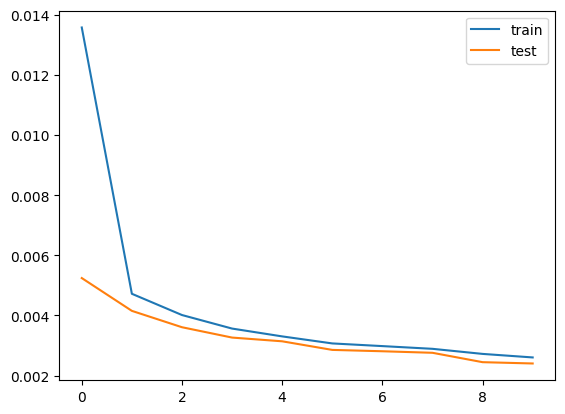

In [113]:
EPOCHS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 32
UPDATE_EVERY_NUM_BATCHES = 1
HIDDEN_CHANNELS = 128

model = VAE().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset, test_dataset = GPUDataset(train_data), GPUDataset(test_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loss_history, test_loss_history = [], []
train_loss_batches, test_loss_batches = [], []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    current_batch = 0
    train_loss, test_loss = 0, 0

    for batch_index, (X, Y) in enumerate(train_dataloader):
        output = model(X)
        loss = loss_fn(output, X)
        loss.backward()
        train_loss_batches.append(loss.item())
        train_loss += loss.item() * len(X)
        if current_batch % UPDATE_EVERY_NUM_BATCHES == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
    train_loss /= len(train_data)
    train_loss_history.append(train_loss)
    print(f"T | E {epoch + 1:,}/{EPOCHS:,} - {((epoch + 1) / EPOCHS) * 100:.3f}% | Loss: {train_loss:.5f}")

    model.eval()
    with torch.inference_mode():
        for batch_index, (X, Y) in enumerate(test_dataloader):
            output = model(X)
            loss = loss_fn(output, X)
            test_loss_batches.append(loss.item())
            test_loss += loss.item() * len(X)
    test_loss /= len(test_data)
    test_loss_history.append(test_loss)
    print(f"V | Loss: {test_loss:.5f}")

import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(["train", "test"])
plt.show()

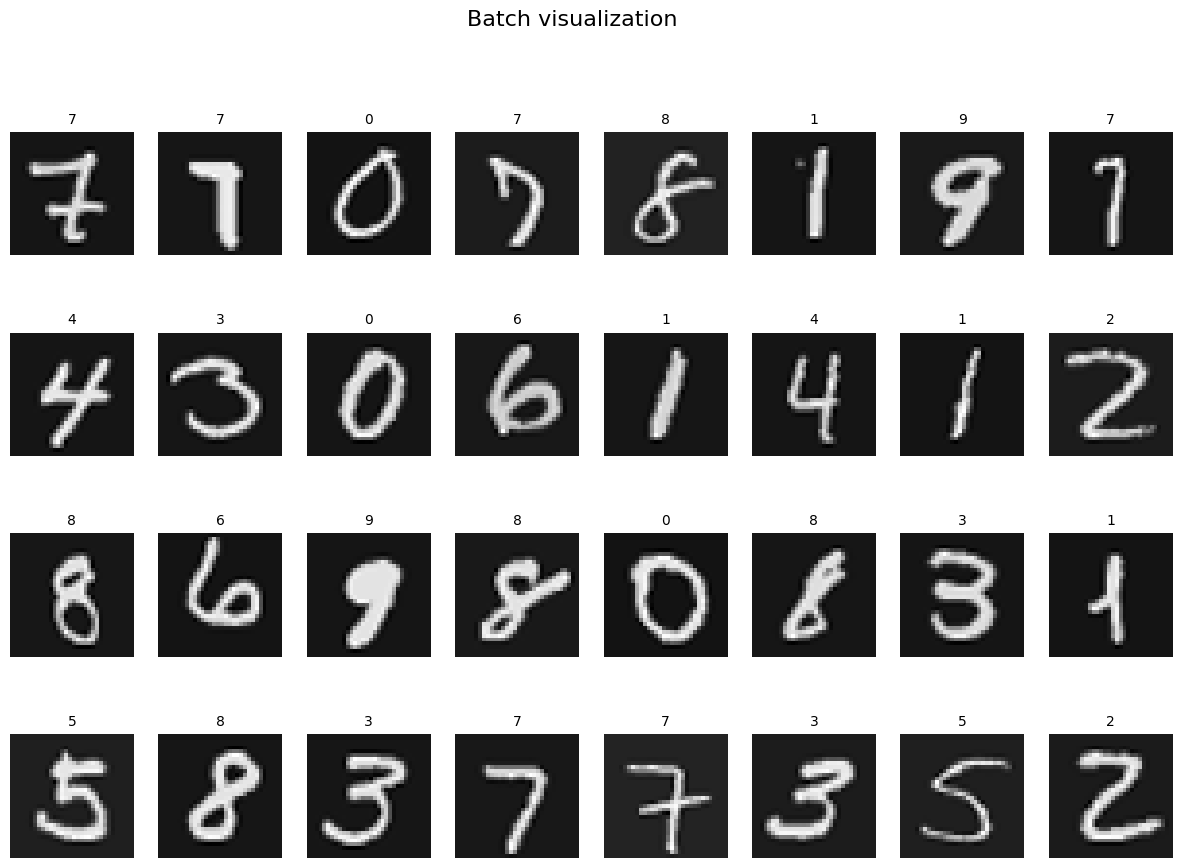

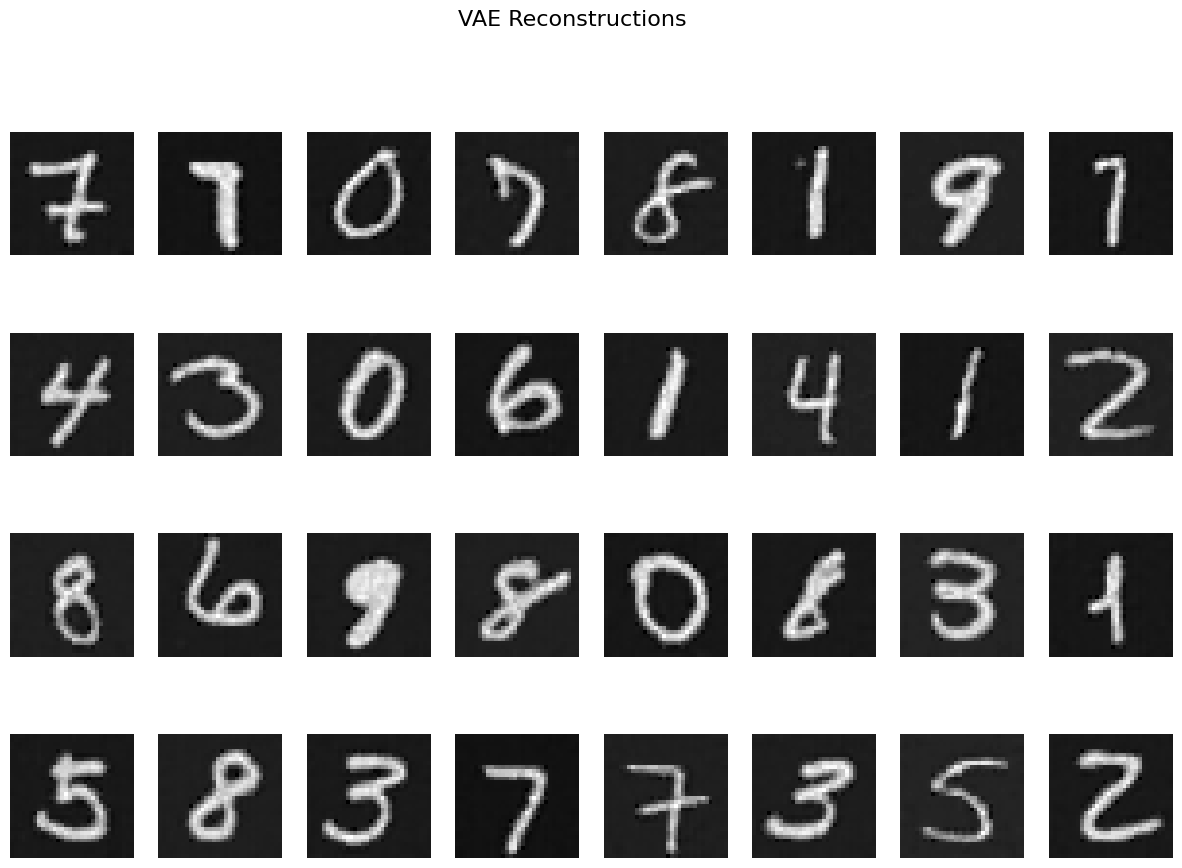

In [114]:
import numpy as np

x_batch, y_batch = next(iter(train_dataloader))
reconstruction = model(x_batch)
x_batch = x_batch.cpu().numpy()

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
fig.suptitle("Batch visualization", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i, 0], cmap="gray")
    ax.set_title(f"{y_batch[i].item()}", fontsize=10)
    ax.axis("off")  # Hide axes

plt.show()

reconstruction = reconstruction.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 10))
fig.suptitle("VAE Reconstructions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(reconstruction[i, 0], cmap="gray")
    ax.axis("off")  # Hide axes

plt.show()